# Image Caption Generator using ResNet and Transformer Decoder Model. It can be divided into 2 steps :
## **Step 1** : Create features for Images Using Resnet
## **Step 2** : Train Transformer Decoder Model which predicts next word given a sequence of tokens and Image Features from Step1

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.auto import tqdm
import math
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
pd.set_option('display.max_colwidth', None)

C:\Users\sapat\AppData\Roaming\Python\Python312\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


cuda


## Read Data.

In [ ]:
df = pd.read_csv(r".\flickr30k_images\results.csv", sep='|')
print(len(df))
display(df.head(3))

158915


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their hands while hanging out in the yard .
1,1000092795.jpg,1,"Two young , White males are outside near many bushes ."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .


## Preprocessing step -> Remove Single Character and non alpha Words. Add tokens. 

In [3]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [4]:
df['cleaned_caption'] = df[' comment'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in str(caption).split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [5]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

74


In [6]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

## Create vocab and map tokens to ID.

In [7]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [8]:
vocab_size = len(word_dict)
print(vocab_size)

17893


In [9]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}

In [10]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

## Train-Validation 80-20 split

In [11]:
df = df.sort_values(by = 'image_name')
train = df.iloc[:int(0.8*len(df))]
valid = df.iloc[int(0.8*len(df)):]

## Extract features from Images Using Resnet

In [12]:
train_samples = len(train)
print(train_samples)

127132


In [13]:
unq_train_imgs = train[['image_name']].drop_duplicates()
unq_valid_imgs = valid[['image_name']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

25427 6357


In [ ]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image_name']
        img_loc = './flickr30k_images/flickr30k_images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [15]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [16]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [17]:
resnet50 = torchvision.models.resnet50(pretrained=True).to(device)
resnet50.eval()
list(resnet50._modules)

C:\Users\sapat\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sapat\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [18]:
resNet50Layer4 = resnet50._modules.get('layer4').to(device)

In [19]:
def get_vector(t_img):
    
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 2048, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    
    h = resNet50Layer4.register_forward_hook(copy_data)
    resnet50(t_img)
    
    h.remove()
    return my_embedding

In [20]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
    
    extract_imgFtr_ResNet_train[image_name[0]] = embdg
    

  0%|          | 0/25427 [00:00<?, ?it/s]

In [21]:
a_file = open("./EncodedImageTrainResNetBest.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [22]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
 
    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/6357 [00:00<?, ?it/s]

In [23]:
a_file = open("./EncodedImageValidResNetBest.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

## Create DataLoader to load the data into Transformer Model.
## FlickerDataSetResnet will return 1 timestep left shifted caption sequence which model will predict and store image features from ResNet.

In [12]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image_name']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [13]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNetBest.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 16, shuffle=True)

In [14]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNetBest.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 16, shuffle=True)

## Transformer Decoder Model

### Position Embedding

In [15]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

## Transformer Decoder

In [16]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


##  Train the Model

In [29]:
EPOCH = 10

In [30]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 2048).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float64('Inf')

c:\Users\sapat\anaconda3\envs\image_ccap\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [31]:
train_loss = []
val_loss = []

train_loss.append(10)
train_loss = []

for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )

    train_loss.append(total_epoch_train_loss)
    val_loss.append(total_epoch_valid_loss)
    
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel1')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\sapat\anaconda3\envs\image_ccap\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  3.803161144256592 Eval Loss ->  3.6454780101776123
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  3.0246963500976562 Eval Loss ->  3.48132586479187
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  2.6241416931152344 Eval Loss ->  3.4995877742767334
Epoch ->  3  Training Loss ->  2.287682056427002 Eval Loss ->  3.600818634033203
Epoch ->  4  Training Loss ->  1.9935283660888672 Eval Loss ->  3.7117655277252197
Epoch ->  5  Training Loss ->  1.6213274002075195 Eval Loss ->  3.8836984634399414
Epoch ->  6  Training Loss ->  1.3934955596923828 Eval Loss ->  4.038120746612549
Epoch ->  7  Training Loss ->  1.230358362197876 Eval Loss ->  4.180640697479248
Epoch ->  8  Training Loss ->  1.0032180547714233 Eval Loss ->  4.355172634124756
Epoch ->  9  Training Loss ->  0.8871938586235046 Eval Loss ->  4.499934196472168


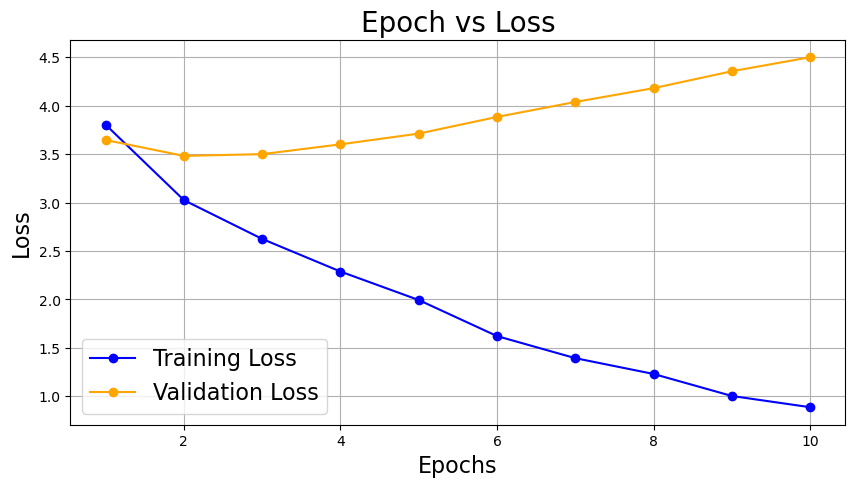

In [32]:
import matplotlib.pyplot as plt
import pickle  # or json depending on how you saved the data

# Extract training and validation loss lists
train_loss = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_loss]
val_loss = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_loss]

epochs = range(1, len(train_loss) + 1)  # Adjust if your epochs start from 0

# Plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Epoch vs Loss', fontsize = 20)
plt.legend(fontsize = 16)
plt.grid()
plt.show()
